### Batches

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import os
import pickle
import copy
from PIL import Image
from skimage import exposure

In [2]:
def saveToPickle(data, file_name=None, folder_path=None):
    if not os.path.isdir(folder_path):
        #print("Create \"preprocessed-data\" folder")
        os.mkdir(folder_path)
    else:
        print("\"preprocessed-data\" folder already exist")

    file_name = folder_path + file_name
    if not os.path.exists(file_name):
        try:
            with open(file_name, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
                print("Create", file_name)
        except Exception as e:
            print('Error: unable to save data to', file_name, 'because', e)
            
def loadPickle(file_name=None, folder_path=None):
    file = folder_path + file_name
    #print('Load')
    if os.path.exists(file):
        try:
            with open(file, 'rb') as f:
                return pickle.load(f)
                print("Open", file)
        except Exception as e:
            print('Error: unable to open data to', file, 'because', e)

In [3]:
## Load
augmented_X_train = loadPickle(file_name='augmented_X_train.p', folder_path='./preprocessed-data/')
augmented_y_train = loadPickle(file_name='augmented_y_train.p', folder_path='./preprocessed-data/')

augmented_X_valid = loadPickle(file_name='augmented_X_valid.p', folder_path='./preprocessed-data/')
augmented_y_valid = loadPickle(file_name='augmented_y_valid.p', folder_path='./preprocessed-data/')

augmented_X_test = loadPickle(file_name='augmented_X_test.p', folder_path='./preprocessed-data/')
augmented_y_test = loadPickle(file_name='augmented_y_test.p', folder_path='./preprocessed-data/')

print('The shape of the loaded processed X train dataset:', augmented_X_train.shape)
print('The shape of the loaded processed y train dataset:', augmented_y_train.shape)

print('The shape of the loaded processed X valid dataset:', augmented_X_valid.shape)
print('The shape of the loaded processed y valid dataset:', augmented_y_valid.shape)

print('The shape of the loaded processed X test dataset:', augmented_X_test.shape)
print('The shape of the loaded processed y test dataset:', augmented_y_test.shape)

The shape of the loaded processed X train dataset: (86430, 32, 32)
The shape of the loaded processed y train dataset: (86430,)
The shape of the loaded processed X valid dataset: (10320, 32, 32)
The shape of the loaded processed y valid dataset: (10320,)
The shape of the loaded processed X test dataset: (32250, 32, 32)
The shape of the loaded processed y test dataset: (32250,)


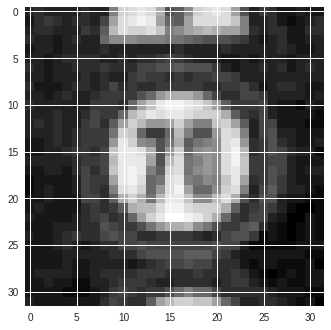

In [4]:
plt.imshow(augmented_X_train[7806], cmap='gray')

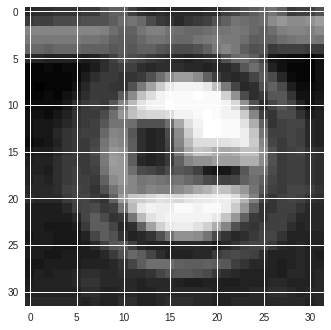

In [5]:
plt.imshow(augmented_X_valid[2306], cmap='gray')

In [6]:
import math
def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    if batch_size > 0:
        assert len(features) == len(labels)

        output_batches = []
        sample_size = len(features)

        for start_i in range(0, sample_size, batch_size):
            end_i = start_i + batch_size
            batch = [features[start_i:end_i], labels[start_i:end_i]]
            output_batches.append(batch)
    else:
        assert len(features) == len(labels)
        
        output_batches = []
        sample_size = len(features)
        
        for start in range(sample_size):
            batch = [features[start], labels[start]]
            output_batches.append(batch)
            
    return output_batches

### Model Architecture

In [7]:
from tensorflow.contrib.layers import flatten

def InceptionModule(x, inputDepth):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # 1x1 convolution
    a_conv_W_1x1 = tf.Variable(tf.truncated_normal(shape=(1, 1, inputDepth, 6), mean = mu, stddev = sigma))
    a_conv_b_1x1 = tf.Variable(tf.zeros(6))
    a_conv_1x1   = tf.nn.conv2d(x, a_conv_W_1x1, strides=[1, 1, 1, 1], padding='SAME') + a_conv_b_1x1
    print('a_conv_1x1:', np.shape(a_conv_1x1))
    
    # 3x3 convolution after 1x1 convolution
    b_conv_W_3x3 = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 32), mean = mu, stddev = sigma))
    b_conv_b_3x3 = tf.Variable(tf.zeros(32))
    b_conv_3x3   = tf.nn.conv2d(a_conv_1x1, b_conv_W_3x3, strides=[1, 1, 1, 1], padding='SAME') + b_conv_b_3x3
    print('b_conv_3x3:', np.shape(b_conv_3x3))
    
    # 5x5 convolution after 1x1 convolution
    c_conv_W_5x5 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 43), mean = mu, stddev = sigma))
    c_conv_b_5x5 = tf.Variable(tf.zeros(43))
    c_conv_5x5   = tf.nn.conv2d(a_conv_1x1, c_conv_W_5x5, strides=[1, 1, 1, 1], padding='SAME') + c_conv_b_5x5
    print('c_conv_5x5:', np.shape(c_conv_5x5))
    
    # Pooling
    d_pooling = tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')
    print('d_Pooling:', np.shape(d_pooling))
    
    # 1x1 convolution after Pooling
    d_conv_W_1x1 = tf.Variable(tf.truncated_normal(shape=(1, 1, inputDepth, 6), mean = mu, stddev = sigma))
    d_conv_b_1x1 = tf.Variable(tf.zeros(6))
    d_conv_1x1   = tf.nn.conv2d(d_pooling, d_conv_W_1x1, strides=[1, 1, 1, 1], padding='SAME') + d_conv_b_1x1
    print('d_conv_1x1:', np.shape(d_conv_1x1))
    
    inceptionOutput = tf.concat([a_conv_1x1, b_conv_3x3, c_conv_5x5, d_conv_1x1], 3)
    print('Inception Output:', np.shape(inceptionOutput))
    return inceptionOutput

def Model(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ## Layer 1: ##
    # Convolutional. Input = 32x32x1. Output = output 30x30x6
    L1_conv_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 6), mean = mu, stddev = sigma))
    L1_conv_b = tf.Variable(tf.zeros(6))
    L1_conv   = tf.nn.conv2d(x, L1_conv_W, strides=[1, 1, 1, 1], padding='VALID') + L1_conv_b
    print('L1-1:', np.shape(L1_conv))
    
    # Activation.
    L1_conv = tf.nn.relu(L1_conv)
    # conv = tf.nn.dropout(conv, 0.7)
    print('L1-2:', np.shape(L1_conv))
    
    ## Layer 2 ##
    # Convolutional. Input = 30x30x6. Output = 28x28x16.
    L2_conv_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 16), mean = mu, stddev = sigma))
    L2_conv_b = tf.Variable(tf.zeros(16))
    L2_conv   = tf.nn.conv2d(L1_conv, L2_conv_W, strides=[1, 1, 1, 1], padding='VALID') + L2_conv_b
    print('L2-1:', np.shape(L2_conv))
    
    # Activation.
    L2_conv = tf.nn.relu(L2_conv)
    #conv1 = tf.nn.dropout(conv1, 0.7)
    print('L2-2:', np.shape(L2_conv))

    # Pooling. Input = 28x28x16. Output = 14x14x16.
    L2_conv = tf.nn.max_pool(L2_conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    L2_depth = np.shape(L2_conv)[3].value
    print('L2-3:', np.shape(L2_conv))
    
    ## Layer 3: ##
    # Inception. Output = 10x10x64.
    L3_inception = InceptionModule(L2_conv, L2_depth)
    print('L3-1:', np.shape(L3_inception))
    
    # Activation.
    L3_inception = tf.nn.relu(L3_inception)
    L3_inception = tf.nn.dropout(L3_inception, 0.5)
    print('L3-2:', np.shape(L3_inception))
    
    ## Layer 4: ##
    # Convolutional. Input = 14x14x108. Output = 12x12x320.
    L4_conv_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 87, 230), mean = mu, stddev = sigma))
    L4_conv_b = tf.Variable(tf.zeros(230))
    L4_conv   = tf.nn.conv2d(L3_inception, L4_conv_W, strides=[1, 1, 1, 1], padding='VALID') + L4_conv_b
    print('L4-1:', np.shape(L4_conv))
    # Activation.
    L4_conv = tf.nn.relu(L4_conv)
    L4_conv = tf.nn.dropout(L4_conv, 0.7)

    # Pooling. Input = 12x12x320. Output = 3x3x320.
    L4_conv = tf.nn.max_pool(L4_conv, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='VALID')
    print('L4-2:', np.shape(L4_conv))

    # Flatten. Input = 3x3x320. Output = 2880.
    fc0   = flatten(L4_conv)
    print('fc0:', np.shape(fc0))
    
    ## Layer 5: ## 
    # Fully Connected. Input = 2880. Output = 1200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(2070, 1700), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1700))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    print('fc1:', np.shape(fc0))
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, 0.5)

    ## Layer 5: ##
    # Fully Connected. Input = 1200. Output = 430.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(1700, 800), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(800))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, 0.5)
    print('fc2:', np.shape(fc0))
    
    # Layer 6: Fully Connected. Input = 430. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

### Train, Validate and Test the Model

In [8]:
rate = 0.001
EPOCHS = 30
BATCH_SIZE = 128

In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

## Features and Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [10]:
## Training Pipeline
#logits =  LeNet(x)
logits = Model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

L1-1: (?, 30, 30, 6)
L1-2: (?, 30, 30, 6)
L2-1: (?, 28, 28, 16)
L2-2: (?, 28, 28, 16)
L2-3: (?, 14, 14, 16)
a_conv_1x1: (?, 14, 14, 6)
b_conv_3x3: (?, 14, 14, 32)
c_conv_5x5: (?, 14, 14, 43)
d_Pooling: (?, 14, 14, 16)
d_conv_1x1: (?, 14, 14, 6)
Inception Output: (?, 14, 14, 87)
L3-1: (?, 14, 14, 87)
L3-2: (?, 14, 14, 87)
L4-1: (?, 10, 10, 230)
L4-2: (?, 3, 3, 230)
fc0: (?, 2070)
fc1: (?, 2070)
fc2: (?, 2070)


In [11]:
## Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, batch_size, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()

    for batch_x, batch_y in tqdm(batches(batch_size, X_data, y_data)):
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
## Reshape dataset
augmented_X_train = np.reshape(augmented_X_train, (len(augmented_X_train), 32, 32, 1))
augmented_X_valid = np.reshape(augmented_X_valid, (len(augmented_X_valid), 32, 32, 1))
augmented_X_test = np.reshape(augmented_X_test, (len(augmented_X_test), 32, 32, 1))
print(augmented_X_train[:128].shape)

(128, 32, 32, 1)


In [13]:
%%time
## Train the Model

#accuracyRate = []

with tf.Session() as session:
    session.run(tf. global_variables_initializer())
    num_examples = len(augmented_X_train)
    
    print("Training...")
    #print()
    for i in range(EPOCHS):
        shuffle_X, shuffle_y = shuffle(augmented_X_train, augmented_y_train)
        for batch_x, batch_y in tqdm(batches(BATCH_SIZE, shuffle_X, shuffle_y)):
            session.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        train_accuracy = evaluate(augmented_X_train, augmented_y_train, BATCH_SIZE, session)
        validation_accuracy = evaluate(augmented_X_valid, augmented_y_valid, BATCH_SIZE, session)
        test_accuracy = evaluate(augmented_X_test, augmented_y_test, BATCH_SIZE, session)
        
        print("EPOCH {0} ...".format(i+1))
        print('Train Accuracy = {:.3f}'.format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Test Accuracy = {:.3f}".format(test_accuracy))

  0%|          | 0/676 [00:00<?, ?it/s]

Training...


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 1 ...
Train Accuracy = 0.767
Validation Accuracy = 0.689
Test Accuracy = 0.663


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 2 ...
Train Accuracy = 0.911
Validation Accuracy = 0.836
Test Accuracy = 0.818


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 3 ...
Train Accuracy = 0.944
Validation Accuracy = 0.873
Test Accuracy = 0.854


  0%|          | 2/676 [00:00<00:49, 13.63it/s]

EPOCH 4 ...
Train Accuracy = 0.957
Validation Accuracy = 0.879
Test Accuracy = 0.869


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 5 ...
Train Accuracy = 0.967
Validation Accuracy = 0.898
Test Accuracy = 0.883


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 6 ...
Train Accuracy = 0.974
Validation Accuracy = 0.910
Test Accuracy = 0.893


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 7 ...
Train Accuracy = 0.981
Validation Accuracy = 0.921
Test Accuracy = 0.904


  0%|          | 2/676 [00:00<00:49, 13.64it/s]

EPOCH 8 ...
Train Accuracy = 0.970
Validation Accuracy = 0.907
Test Accuracy = 0.894


  0%|          | 2/676 [00:00<00:49, 13.58it/s]

EPOCH 9 ...
Train Accuracy = 0.979
Validation Accuracy = 0.929
Test Accuracy = 0.901


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 10 ...
Train Accuracy = 0.979
Validation Accuracy = 0.931
Test Accuracy = 0.908


  0%|          | 2/676 [00:00<00:49, 13.71it/s]

EPOCH 11 ...
Train Accuracy = 0.985
Validation Accuracy = 0.926
Test Accuracy = 0.907


  0%|          | 2/676 [00:00<00:49, 13.67it/s]

EPOCH 12 ...
Train Accuracy = 0.986
Validation Accuracy = 0.937
Test Accuracy = 0.910


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 13 ...
Train Accuracy = 0.986
Validation Accuracy = 0.930
Test Accuracy = 0.913


  0%|          | 2/676 [00:00<00:49, 13.69it/s]

EPOCH 14 ...
Train Accuracy = 0.987
Validation Accuracy = 0.936
Test Accuracy = 0.911


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 15 ...
Train Accuracy = 0.989
Validation Accuracy = 0.937
Test Accuracy = 0.911


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 16 ...
Train Accuracy = 0.986
Validation Accuracy = 0.936
Test Accuracy = 0.908


  0%|          | 2/676 [00:00<00:49, 13.68it/s]

EPOCH 17 ...
Train Accuracy = 0.989
Validation Accuracy = 0.934
Test Accuracy = 0.921


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 18 ...
Train Accuracy = 0.988
Validation Accuracy = 0.941
Test Accuracy = 0.915


  0%|          | 2/676 [00:00<00:49, 13.64it/s]

EPOCH 19 ...
Train Accuracy = 0.983
Validation Accuracy = 0.937
Test Accuracy = 0.913


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 20 ...
Train Accuracy = 0.989
Validation Accuracy = 0.942
Test Accuracy = 0.920


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 21 ...
Train Accuracy = 0.990
Validation Accuracy = 0.938
Test Accuracy = 0.921


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 22 ...
Train Accuracy = 0.991
Validation Accuracy = 0.947
Test Accuracy = 0.922


  0%|          | 2/676 [00:00<00:49, 13.64it/s]

EPOCH 23 ...
Train Accuracy = 0.991
Validation Accuracy = 0.940
Test Accuracy = 0.920


  0%|          | 2/676 [00:00<00:49, 13.71it/s]

EPOCH 24 ...
Train Accuracy = 0.988
Validation Accuracy = 0.942
Test Accuracy = 0.916


  0%|          | 2/676 [00:00<00:49, 13.72it/s]

EPOCH 25 ...
Train Accuracy = 0.989
Validation Accuracy = 0.946
Test Accuracy = 0.918


  0%|          | 2/676 [00:00<00:50, 13.44it/s]

EPOCH 26 ...
Train Accuracy = 0.992
Validation Accuracy = 0.948
Test Accuracy = 0.921


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 27 ...
Train Accuracy = 0.986
Validation Accuracy = 0.939
Test Accuracy = 0.909


  0%|          | 2/676 [00:00<00:49, 13.65it/s]

EPOCH 28 ...
Train Accuracy = 0.992
Validation Accuracy = 0.944
Test Accuracy = 0.924


  0%|          | 0/676 [00:00<?, ?it/s]

EPOCH 29 ...
Train Accuracy = 0.992
Validation Accuracy = 0.944
Test Accuracy = 0.924


100%|██████████| 252/252 [00:04<00:00, 53.51it/s]

EPOCH 30 ...
Train Accuracy = 0.988
Validation Accuracy = 0.937
Test Accuracy = 0.910
CPU times: user 24min 35s, sys: 4min 40s, total: 29min 16s
Wall time: 34min 33s


In [ ]:
saver.save(session, './CNN1')
print("Model Saved")